<a href="https://colab.research.google.com/github/mushrafi88/tesserect_dnn_sudoku_solver/blob/main/Copy_of_tesserect_dnn_conv2_image%5Bbox%5D_extractor%2Bsudoku_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting the stage for data collection from image

## set up environment

In [12]:
!pip install opencv-python opencv-python-headless pytesseract numpy
!apt-get install -y tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 3s (1,867 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database .

In [49]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
from IPython.display import display, Image
from PIL import Image as PilImage
import io
import re
import matplotlib.pyplot as plt
import tensorflow as tf
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

In [52]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    return thresh

def find_largest_contour(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return contours[0]

def extract_sudoku_board(image_path):
    preprocessed_image = preprocess_image(image_path)
    largest_contour = find_largest_contour(preprocessed_image)

    rect = cv2.minAreaRect(largest_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    warped = four_point_transform(preprocessed_image, box)

    return warped

def four_point_transform(image, rect):
    rect = rect[np.argsort(rect[:, 1])]
    top_points = rect[:2]
    bottom_points = rect[2:]

    top_points = top_points[np.argsort(top_points[:, 0])]
    bottom_points = bottom_points[np.argsort(bottom_points[:, 0])]

    tl, tr, bl, br = *top_points, *bottom_points

    width_top = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    width_bottom = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    max_width = max(int(width_top), int(width_bottom))

    height_left = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    height_right = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    max_height = max(int(height_left), int(height_right))

    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype="float32")

    src = np.array([tl, tr, br, bl], dtype="float32")
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (max_width, max_height))

    return warped

def save_sudoku_cells(sudoku_board):
    height, width = sudoku_board.shape
    cell_height, cell_width = height // 9, width // 9

    for row in range(9):
        for col in range(9):
            cell = sudoku_board[row * cell_height:(row + 1) * cell_height, col * cell_width:(col + 1) * cell_width]
            cv2.imwrite(f'cell_{row}_{col}.png', cell)

def display_sudoku_cells(sudoku_board):
    height, width = sudoku_board.shape
    cell_height, cell_width = height // 9, width // 9

    fig, axes = plt.subplots(9, 9, figsize=(10, 10))

    for row in range(9):
        for col in range(9):
            cell = sudoku_board[row * cell_height:(row + 1) * cell_height, col * cell_width:(col + 1) * cell_width]
            axes[row, col].imshow(cell, cmap='gray')
            axes[row, col].axis('off')

    plt.show()

In [62]:
def get_number_from_cell(cell):
    config = '--oem 1 -l eng --psm 6 -c tessedit_char_whitelist=123456789 invert=true textord_heavy_nr=1' 
    text = pytesseract.image_to_string(cell, config=config)
    digits = re.findall('\d', text)
    return int(digits[0]) if digits else 0

def extract_numbers_from_cells(sudoku_board):
    height, width = sudoku_board.shape
    cell_height, cell_width = height // 9, width // 9
    sudoku_numbers = np.zeros((9, 9), dtype=int)

    for row in range(9):
        for col in range(9):
            cell = sudoku_board[row * cell_height:(row + 1) * cell_height, col * cell_width:(col + 1) * cell_width]
            number = get_number_from_cell(cell)
            sudoku_numbers[row, col] = number

    return sudoku_numbers

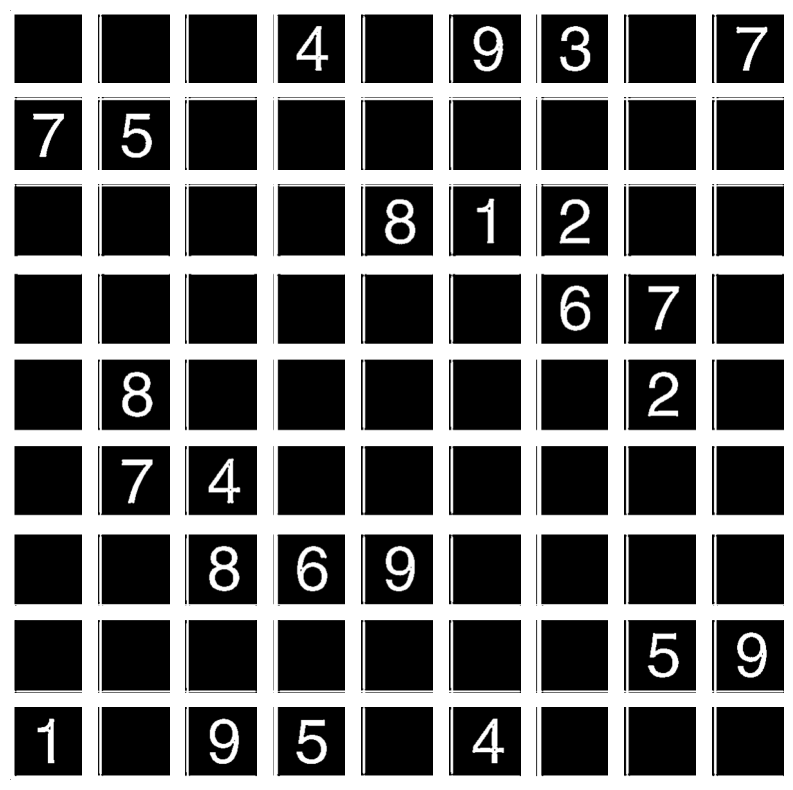

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 7, 0, 7, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 7, 0, 0, 7, 1, 0, 0],
       [0, 0, 7, 0, 0, 7, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 6, 0, 7, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 4, 0, 0, 0]])

In [63]:
image_path = "image.jpg"  # Change
sudoku_board = extract_sudoku_board(image_path)
save_sudoku_cells(sudoku_board)
display_sudoku_cells(sudoku_board)
sudoku_numbers = extract_numbers_from_cells(sudoku_board)
sudoku_numbers

array([[0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 5, 7, 0, 0, 0, 0, 0, 0],
       [0, 7, 7, 0, 0, 4, 0, 0, 0],
       [0, 7, 7, 0, 0, 0, 6, 0, 0],
       [0, 8, 7, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 3, 6, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [9]:
#img1 = 'Sudoku-Easy-Puzzle-Printable.png'
#!wget https://free-printablehq.com/wp-content/uploads/2019/07/5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg

--2023-04-28 12:29:15--  https://free-printablehq.com/wp-content/uploads/2019/07/5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg
Resolving free-printablehq.com (free-printablehq.com)... 172.67.173.88, 104.21.80.26, 2606:4700:3032::6815:501a, ...
Connecting to free-printablehq.com (free-printablehq.com)|172.67.173.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg’

5-best-photos-of-su     [ <=>                ] 132.15K  --.-KB/s    in 0.03s   

2023-04-28 12:29:16 (4.65 MB/s) - ‘5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg’ saved [135324]



In [ ]:
!wget -O eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/master/eng.traineddata?raw=true
!cp /content/eng.traineddata /usr/local/share/tessdata/

--2022-02-09 15:38:09--  https://github.com/tesseract-ocr/tessdata/blob/master/eng.traineddata?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata [following]
--2022-02-09 15:38:10--  https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘eng.traineddata’

eng.traineddata         [ <=>                ] 171.99K  --.-KB/s    in 0.1s    

2022-02-09 15:38:10 (1.45 MB/s) - ‘eng.traineddata’ saved [176117]



In [ ]:
!pip install pytesseract

try:
 from PIL import Image
except ImportError:
 import Image

  Preparing metadata (setup.py) ... done
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14070 sha256=e682202c76e7b6b2080243f289b203ce296219ab0db656cd5b75fe8c73361eeb
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [ ]:
import pytesseract
import cv2 
import imutils
import numpy as np
from PIL import ImageEnhance, ImageFilter, Image

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
tessdata_dir_config = r'--tessdata-dir "/usr/local/tesseract/tessdata"'

In [ ]:
!which tesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/local/bin/tesseract')

/usr/local/bin/tesseract


## functions

In [ ]:
def resize_gray_gaussian(image):
  img_1 = cv2.resize(image, None, fx=0.5, fy=0.5)
  gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
  adaptive_threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 85, 11)
  return adaptive_threshold#black and white img

In [ ]:
def detect_box(image,line_min_width=15):
    #gray_scale=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    th1,img_bin=cv2.threshold(image,150,225,cv2.THRESH_BINARY)
    kernal_h=np.ones((1,line_min_width), np.uint8)
    kernal_v=np.ones((line_min_width,1), np.uint8)
    img_bin_h=cv2.morphologyEx(~img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v=cv2.morphologyEx(~img_bin, cv2.MORPH_OPEN, kernal_v)
    img_bin_final=img_bin_h|img_bin_v
    final_kernel=np.ones((3,3), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    ret, labels, stats,centroids = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    return stats,labels

In [ ]:
def pillars_81_(image):
  stats,labels=detect_box(image)
  x = stats[:,2]
  x = x[(x >= x.mean()/2) & (x <= 2*x.mean())]
  boxes = stats[ (stats[:,2] < 1.8*x.mean() ) & (stats[:,2] > 0.8*x.mean() ) ]
  if len(boxes) == 81:
    return boxes
  else:
    print("take a good and clear picture")

In [ ]:
def format_for_csv(image):
  config = "-c tessedit_char_whitelist=123456789 --psm 10 --oem 0"
  arr = []
  boxes=pillars_81_(image)
  for num in range(81):
    x,y,w,h,area = boxes[num]
    h = int(h*0.95)
    w = int(w*0.95)
    crop_img = image[y:y+h, x:x+w]
    #crop_img = cv2.bitwise_not(crop_img)
    cv2_imshow(crop_img)
    text = pytesseract.image_to_string(crop_img, config=config)
    print(text)
    if len(text) == 3:
      if text[0] == 'a':
        arr.append('0')
      else:
        arr.append(text[0])
    elif len(text) == 1:
      arr.append('0')    
  sum = arr[0]  
  for i in range(1,81):
    sum = sum + arr[i]     

  res = [int(i) for i in arr]
  return sum,res

# Training the model

In [ ]:
#https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning

# Feeding the model :)

In [ ]:
import copy
import keras
import numpy as np

In [ ]:
!wget -O sudoku.model https://github.com/shivaverma/Sudoku-Solver/blob/master/model/sudoku.model?raw=true

--2022-02-09 15:38:45--  https://github.com/shivaverma/Sudoku-Solver/blob/master/model/sudoku.model?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/shivaverma/Sudoku-Solver/raw/master/model/sudoku.model [following]
--2022-02-09 15:38:46--  https://github.com/shivaverma/Sudoku-Solver/raw/master/model/sudoku.model
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shivaverma/Sudoku-Solver/master/model/sudoku.model [following]
--2022-02-09 15:38:46--  https://raw.githubusercontent.com/shivaverma/Sudoku-Solver/master/model/sudoku.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443..

In [ ]:
model = keras.models.load_model('sudoku.model')

In [ ]:
#https://github.com/shivaverma/Sudoku-Solver/blob/master/sudoku.ipynb
def norm(a):
    
    return (a/9)-.5

def denorm(a):
    
    return (a+.5)*9   

def inference_sudoku(sample):
    
    '''
        This function solve the sudoku by filling blank positions one by one.
    '''
    
    feat = copy.copy(sample)
    
    while(1):
    
        out = model.predict(feat.reshape((1,9,9,1)))  
        out = out.squeeze()

        pred = np.argmax(out, axis=1).reshape((9,9))+1 
        prob = np.around(np.max(out, axis=1).reshape((9,9)), 2) 
        
        feat = denorm(feat).reshape((9,9))
        mask = (feat==0)
     
        if(mask.sum()==0):
            break
            
        prob_new = prob*mask
    
        ind = np.argmax(prob_new)
        x, y = (ind//9), (ind%9)

        val = pred[x][y]
        feat[x][y] = val
        feat = norm(feat)
    
    return pred     

In [ ]:

def solve_sudoku(game):
    game = norm(game)
    game = inference_sudoku(game)
    return game

# Result time

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#img0 = 'photo_2021-07-16_20-02-46.jpg'
#!wget https://oppidanlibrary.com/wp-content/uploads/2017/05/Sudoku-Easy-Puzzle-Printable.png
img1 = 'Sudoku-Easy-Puzzle-Printable.png'
!wget https://free-printablehq.com/wp-content/uploads/2019/07/5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg
img2 = '5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg'
#!wget https://1.bp.blogspot.com/-msG6TL2pZEU/Tm71-UdjywI/AAAAAAAAK8I/aPqk174NsJY/s1600/easy+sudoku+to+print.jpg
img3 = 'easy+sudoku+to+print.jpg'
#img4 = '/content/drive/MyDrive/digit/5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg'
#img5 = '/content/drive/MyDrive/digit/1200px-Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg.png'

#!wget https://www.sudokuoftheday.com/image/bulletin/BeginnerPuzzle.png
img6 = '/content/BeginnerPuzzle.png'
img7 = '/content/sud_photo_2021-02-23_12-47-17.jpg'
img8 = '/content/2021-02-23_14-33.png'

--2022-02-09 15:39:17--  https://free-printablehq.com/wp-content/uploads/2019/07/5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg
Resolving free-printablehq.com (free-printablehq.com)... 172.67.173.88, 104.21.80.26, 2606:4700:3032::6815:501a, ...
Connecting to free-printablehq.com (free-printablehq.com)|172.67.173.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg’

5-best-photos-of-su     [ <=>                ] 132.15K  --.-KB/s    in 0.09s   

2022-02-09 15:39:17 (1.48 MB/s) - ‘5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg’ saved [135324]



In [ ]:

#img = cv2.imread('/content/drive/MyDrive/digit/5-best-photos-of-super-sudoku-16x16-print-monster-sudoku-16x16-sudoku-16x16-printable-free.jpg')
#img = cv2.imread('/content/drive/MyDrive/digit/1200px-Sudoku_Puzzle_by_L2G-20050714_standardized_layout.svg.png')
# tesseract and others need rgb
#img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.imread(img2)
r_img = resize_gray_gaussian(img)


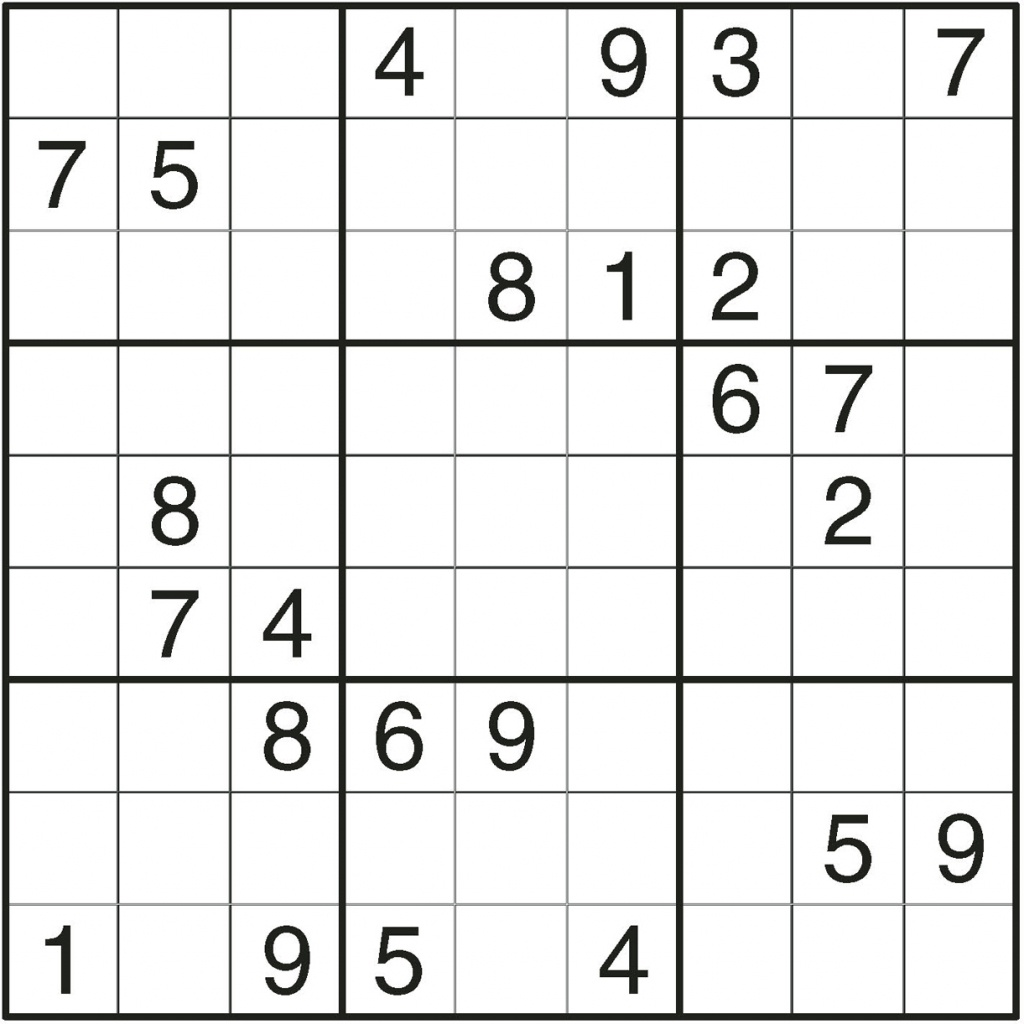

In [ ]:
cv2_imshow(img)

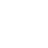

TesseractError: ignored

In [ ]:
sum_form,array_form=format_for_csv(r_img)

In [ ]:
#sum_form

In [ ]:
sudoku_q = np.array(array_form).reshape((9,9,1))

In [ ]:
game = sudoku_q
game = solve_sudoku(game)

print('solved puzzle:\n')
print(game)
print('\n')
if(np.unique(np.sum(game, axis=1),axis=0)[0] == 45
):print('100 % accuracy')

solved puzzle:

[[8 2 6 4 5 9 3 1 7]
 [7 5 1 2 6 3 9 4 8]
 [4 9 3 7 8 1 2 6 5]
 [9 1 2 8 4 5 6 7 3]
 [3 8 5 9 7 6 4 2 1]
 [6 7 4 3 1 2 8 9 5]
 [5 4 8 6 9 7 1 3 2]
 [2 6 7 1 3 8 4 5 9]
 [1 3 9 5 2 4 7 8 6]]


100 % accuracy


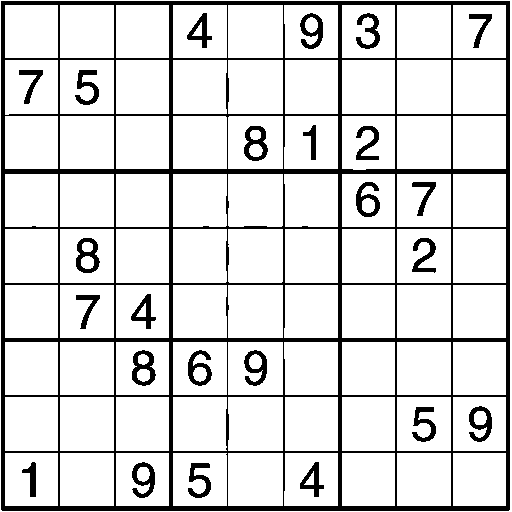

In [ ]:
cv2_imshow(r_img)

# debugging

In [ ]:
stats,labels=detect_box(r_img)

In [ ]:
x = stats[:,2]
x = x[(x >= x.mean()/2) & (x <= 2*x.mean())]

In [ ]:
x.mean()

In [ ]:
boxes = stats[ (stats[:,2] < 1.8*x.mean() ) & (stats[:,2] > 0.8*x.mean() ) ]
boxes

In [ ]:
len(boxes)

In [ ]:
for x,y,w,h,area in boxes:
    cv2.rectangle(r_img,(x,y),(x+w,y+h),(0,255,0),2)
cv2_imshow(r_img)

In [ ]:
x,y,w,h,area = boxes[0]
crop_img = r_img[y:y+h, x:x+w]
cv2_imshow(crop_img)

In [ ]:

# Resize the image
#img_1 = cv2.resize(crop_img, None, fx=0.5, fy=0.5)
#greyscale
#gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)#
# b/w
#adaptive_threshold = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 85, 11)

#cv2_imshow(adaptive_threshold)

In [ ]:
#config = "--psm 10"
#text = pytesseract.image_to_string(adaptive_threshold, config=config)

In [ ]:
#if len(text) == 3:
#  print(text)
#else:
#  print('nyah')  

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Define lower and uppper limits of what we call "brown"
brown_lo=np.array([30,30,30])
brown_hi=np.array([220,220,220])

# Mask image to only select browns
mask=cv2.inRange(hsv,brown_lo,brown_hi)

# Change image to red where we found brown
img[mask>0]=(235,235,235)


cv2_imshow(img)
